# Exam - Sophia Wilson

I use my own library 'AdvAppStatFunctions' which contains many functions that I made in the course Applied Statistics and that I have extended i in this course. I will write at the particular problem if I use any code not made by myself.

In [1]:
# Standard libraires
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import math
import scipy
from scipy import stats, interpolate
from scipy.optimize import minimize
import itertools
from iminuit import Minuit   
import copy
from tqdm.notebook import tqdm

# Nested fitting
import ultranest
from ultranest.plot import cornerplot
from ultranest.plot import PredictionBand


# External library
import sys  
from importlib import reload
sys.path.append('../') 
import AdvAppStatFunctions as aas

# setting for plotting
from matplotlib.patches import ConnectionPatch
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
plt.style.use('seaborn-white')
sns.set_style('white', {'legend.frameon':True})
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 14
sns.set_palette("colorblind")
color = sns.color_palette("colorblind")

from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, log_loss, precision_score
from sklearn.metrics import roc_curve, auc

In [2]:
#import warnings
#warnings.filterwarnings('ignore')

SaveFig = False

# Problem 4A

### Parsing data

In [3]:
data = np.loadtxt('Data/Exam_2023_Prob4.txt', skiprows=1)
data = sorted(data)

### Define x limits, x-array for fit and plot, parameter names and bounds

In [4]:
# x limits for the truncated function
xlim = (min(data),max(data))

# x-array
x_arr = np.linspace(*xlim, 1000)

### PDFs

In [5]:
def gaussian_pdf(x, mu, sigma):
    """Gaussian distribution"""
    return stats.norm.pdf(x, mu, sigma)

# Double Gauss

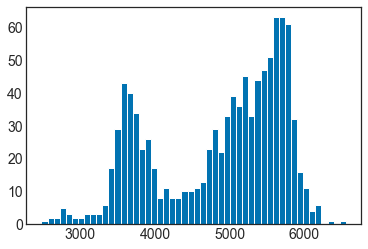

In [6]:
N_bins = 50
fig, ax = plt.subplots()
hist = ax.hist(data, N_bins)
bins = hist[1]
bw = hist[1][1]-hist[1][0]

## Fit first Gauss

The reduced Chi2 is: 5.8771 with a p-value of: 0.0000
[3659.270283091519, 323.3412973606859]


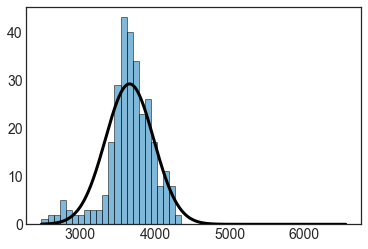

In [7]:
gauss1 = data[0:290] # [20:280]  # 
start_guess_1 = [3680, 50]
par_1, par_err_1, _ = aas.llh_fit(gauss1, gaussian_pdf, start_guess_1, ['mu', 'sigma'])
_, _, _ =  aas.chi2_hist(gauss1, gaussian_pdf, par_1, bins)
print(par_1)

fig, ax = plt.subplots()
ax.hist(gauss1, bins, ec='k', alpha=0.5, zorder=2, label='Data')
y_arr_1 = gaussian_pdf(x_arr, *par_1) * len(gauss1) * bw
ax.plot(x_arr, y_arr_1, color='k', linewidth=3, zorder=3, label='Unbinned llh fit');

## Fit second Gauss


The reduced Chi2 is: 4.3930 with a p-value of: 0.0000
[5334.451935619409, 432.83897290358175]


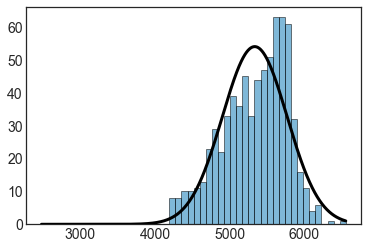

In [8]:
gauss2 = data[280:]
start_guess_2 = [5650, 150]
par_2, par_err_2, negLLH_val_2 = aas.llh_fit(gauss2, gaussian_pdf, start_guess_2, ['mu', 'sigma'])
_, _, _ =  aas.chi2_hist(gauss2, gaussian_pdf, par_2, bins)
print(par_2)

fig, ax = plt.subplots()
ax.hist(gauss2, bins, ec='k', alpha=0.5, zorder=2, label='Data')
y_arr_2 = gaussian_pdf(x_arr, *par_2) * len(gauss2) * bw
ax.plot(x_arr, y_arr_2, color='k', linewidth=3, zorder=3, label='Unbinned llh fit');

## Combine Gauss and normalize

In [9]:
y_pdf = y_arr_1 + y_arr_2
y_pdf /= np.trapz(y_pdf, x_arr)

## Plot the resulting pdf

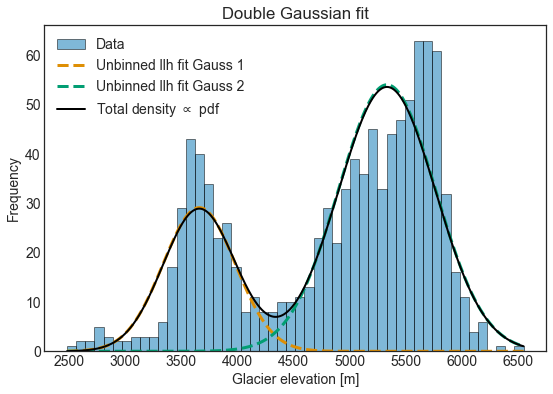

In [10]:
fig, ax = plt.subplots(figsize=(9,6))
hist = ax.hist(data, bins, ec='k', alpha=0.5, zorder=2, label='Data') 


y_arr_1 = gaussian_pdf(x_arr, *par_1) * len(gauss1) * bw
ax.plot(x_arr, y_arr_1, color=color[1], linewidth=3, label='Unbinned llh fit Gauss 1', ls='dashed');

y_arr_2 = gaussian_pdf(x_arr, *par_2) * len(gauss2) * bw
ax.plot(x_arr, y_arr_2, color=color[2], linewidth=3, label='Unbinned llh fit Gauss 2', ls='dashed')
plt.plot(x_arr, y_pdf*len(data)*bw, lw=2, color='k', label = r'Total density $\propto$ pdf')

handles, labels = plt.gca().get_legend_handles_labels()
order = [3, 0, 1, 2]

ax.set(xlabel='Glacier elevation [m]', ylabel='Frequency', title='Double Gaussian fit')
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])



if SaveFig:
    fig.savefig('Figs/4_1.pdf')

## From total density to pdf

In [11]:
def pdf_double(x):
    pdf = gaussian_pdf(x, *par_1) * len(gauss1) * bw + gaussian_pdf(x, *par_2) * len(gauss2) * bw
    pdf /= np.trapz(pdf, x)
    return pdf

# Triple Gauss

### Fit second Gauss again

## Treating them as a double Gauss

In [12]:
def doublegauss(x, mu1, sigma1, mu2, sigma2):
    'Doubble Gaussian distribution'
    return (gaussian_pdf(x, mu1, sigma1) +  gaussian_pdf(x, mu2, sigma2) )/2

The reduced Chi2 is: 2.9001 with a p-value of: 0.0000
[5033.906733133506, 373.8710918812406, 5645.342332692528, 215.56379510240984]


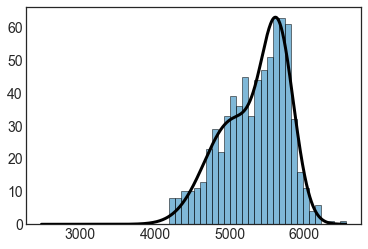

In [13]:
gaussd = data [280:1000] #[290:1000]
start_guess_d = [5000, 100, 5700, 10]
par_d, par_err_d, negLLH_val_d = aas.llh_fit(gaussd, doublegauss, start_guess_d, ['mu1', 'sigma1', 'mu2', 'sigma2'])
_, _, _ =  aas.chi2_hist(gaussd, doublegauss, par_d, bins)
print(par_d)

fig, ax = plt.subplots()
ax.hist(gaussd, bins, ec='k', alpha=0.5, zorder=2, label='Data')
y_arr_d = doublegauss(x_arr, *par_d) * len(gaussd) * bw 
ax.plot(x_arr, y_arr_d, color='k', linewidth=3, zorder=3, label='Unbinned llh fit');
#ax.plot(x_arr, doublegauss(x_arr, *par_22)* len(gauss2) * binwidth_2/3, color='k', linewidth=3, zorder=3, label='Unbinned llh fit');

## Combine Gauss and normalize

In [14]:
y_pdf = y_arr_1 + y_arr_d 
y_pdf /= np.trapz(y_pdf, x_arr)

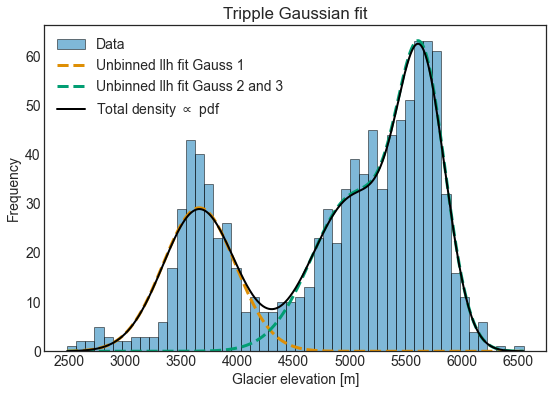

In [15]:
fig, ax = plt.subplots(figsize=(9,6))
hist = ax.hist(data, bins, ec='k', alpha=0.5, zorder=2, label='Data') 

y_arr_1 = gaussian_pdf(x_arr, *par_1) * len(gauss1) * bw
ax.plot(x_arr, y_arr_1, color=color[1], linewidth=3, label='Unbinned llh fit Gauss 1', ls='dashed');

y_arr_d = doublegauss(x_arr, *par_d) * len(gauss2) * bw
ax.plot(x_arr, y_arr_d, color=color[2], linewidth=3, label='Unbinned llh fit Gauss 2 and 3', ls='dashed')
plt.plot(x_arr, y_pdf*len(data)*bw, lw=2, color='k', label = r'Total density $\propto$ pdf')

handles, labels = plt.gca().get_legend_handles_labels()
order = [3, 0, 1, 2]

ax.set(xlabel='Glacier elevation [m]', ylabel='Frequency', title='Tripple Gaussian fit')
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
                                             
if SaveFig:
    fig.savefig('Figs/4_2.pdf');

## From total density to pdf

In [16]:
def pdf_triple(x):
    pdf = gaussian_pdf(x, *par_1) * len(gauss1) * bw + doublegauss(x, *par_d) * len(gaussd) * bw
    pdf /= np.trapz(pdf, x)
    return pdf

In [44]:
def chi2_4B(data, pdf, N_pars, N_bins):
    counts, bin_edges = np.histogram(data, bins=N_bins);
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
    binwidth = bin_edges[1] - bin_edges[0]

    # We remove any bins, which don't have any counts in them:
    x = bin_centers[counts>0]
    y = counts[counts>0]

    # Calculate the expected values (N*binwidth unnormalises it so it fits the histogram)
    y_exp = pdf(x) * len(data) * binwidth 

    # Degrees of freedom
    N_ddof = len(x) - N_pars #n_point - n_parameters, notice n_points is the no. of bin centers

    # Calc chi2 and p value
    chi2 = np.sum( (y-y_exp)**2 / y_exp )  # y_exp = y_err^2
    chi2_reduced = chi2 / N_ddof
    prob = stats.chi2.sf(chi2, df=N_ddof) 
    print(f'The reduced Chi2 is: {chi2_reduced:.4f} with a p-value of: {prob:.4f}')
    
    return chi2_reduced, prob, binwidth, x, y_exp, y

In [19]:
chi2_red_double, prob_double, _, x_d, y_exp_double, y_d =  chi2_4B(data, pdf_double, 4, N_bins)

206.33785017919445
The reduced Chi2 is: 4.6895 with a p-value of: 0.0000


In [20]:
chi2_red_triple, prob_triple, _, x_t, y_exp_triple, y_t =  chi2_4B(data, pdf_triple, 6, N_bins)

180.86971632029358
The reduced Chi2 is: 4.3064 with a p-value of: 0.0000


### Monte Carlo and KS-test

In [21]:
def pdf_double_mc(x):
    pdf = gaussian_pdf(x, *par_1) * len(gauss1) * bw + gaussian_pdf(x, *par_2) * len(gauss2) * bw
    return pdf

def pdf_triple_mc(x):
    pdf = gaussian_pdf(x, *par_1) * len(gauss1) * bw + doublegauss(x, *par_d) * len(gaussd) * bw
    return pdf

In [22]:
xmin, xmax, N_points = min(data), max(data), len(data)

ks_vals_double = []
ks_vals_triple = []
for _ in range(5000):
    X_accepted, Y_accepted, eff = aas.acceptandreject(pdf_double_mc, xmin, xmax, N_points)
    ks_vals_double.append(stats.ks_2samp(X_accepted, data)[1])
    
    X_accepted, Y_accepted, eff = aas.acceptandreject(pdf_triple_mc, xmin, xmax, N_points)
    ks_vals_triple.append(stats.ks_2samp(X_accepted, data)[1])

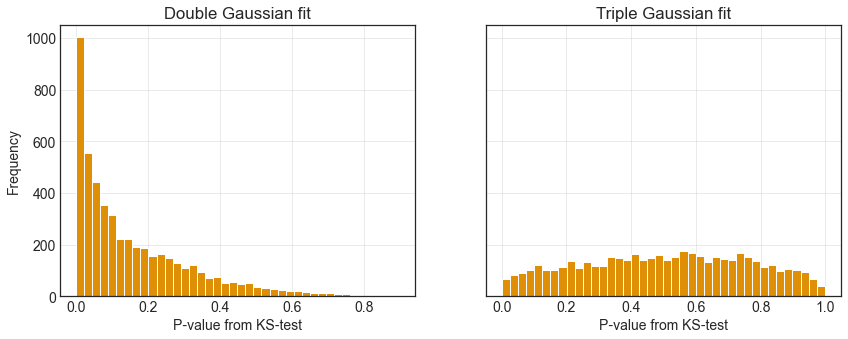

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(14,5), sharey=True)
ax[0].grid(alpha=0.5)
hist_double0 = ax[0].hist(ks_vals_double, color=color[1], bins=40)
ax[1].grid(alpha=0.5)
hist_triple0 = ax[1].hist(ks_vals_triple, color=color[1], bins=40)
ax[0].set(xlabel='P-value from KS-test', ylabel='Frequency', title='Double Gaussian fit')
ax[1].set(xlabel='P-value from KS-test', title='Triple Gaussian fit');

#if SaveFig:
#    fig.savefig('Figs/4_3.pdf');

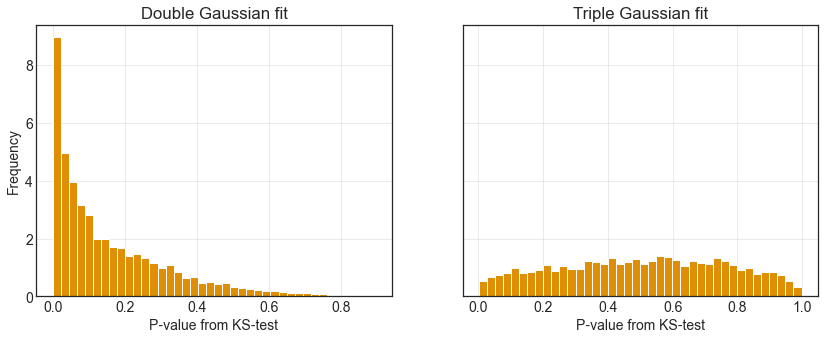

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(14,5), sharey=True)
ax[0].grid(alpha=0.5)
hist_double = ax[0].hist(ks_vals_double, color=color[1], bins=40, density=True)
ax[1].grid(alpha=0.5)
hist_triple = ax[1].hist(ks_vals_triple, color=color[1], bins=40, density=True)
ax[0].set(xlabel='P-value from KS-test', ylabel='Frequency', title='Double Gaussian fit')
ax[1].set(xlabel='P-value from KS-test', title='Triple Gaussian fit');


In [25]:
hist_double_exp = np.ones_like(hist_double[0][:-3])
hist_double_obs = hist_double[0][:-3]
hist_double_err = np.sqrt(hist_double0[0][:-3]) / hist_double0[0][0]/hist_double[0][0]

In [26]:
hist_triple_exp = np.ones_like(hist_triple[0])
hist_triple_obs = hist_triple[0]
hist_triple_err = np.sqrt(hist_triple0[0]) / hist_triple0[0][0]/hist_triple[0][0]

In [29]:
aas.chis_quare_and_prob(hist_double_exp, hist_double_obs, hist_double_err, N_par=20)

(144332184.53815407, 0.0)

In [30]:
aas.chis_quare_and_prob(hist_triple_exp, hist_triple_obs, hist_triple_err, N_par=20)

(37.51316245872794, 0.010149136287445229)

# Nyt forsøg

In [33]:
size = len(data)
N_bins = 50
xmin, xmax = min(data), max(data)
binwidth = (xmax-xmin)/N_bins

In [34]:
def threegauss(x, N1, N2, N3, mu1, mu2, mu3, sigma1, sigma2, sigma3):
    'Doubble Gaussian distribution'
    return N1 * gaussian_pdf(x, mu1, sigma1) +  N2 * gaussian_pdf(x, mu2, sigma2) + N3 * gaussian_pdf(x, mu3, sigma3)

def threegauss_plot(x, N1, N2, N3, mu1, mu2, mu3, sigma1, sigma2, sigma3):
    'Doubble Gaussian distribution'
    return binwidth*threegauss(x, N1, N2, N3, mu1, mu2, mu3, sigma1, sigma2, sigma3)
 

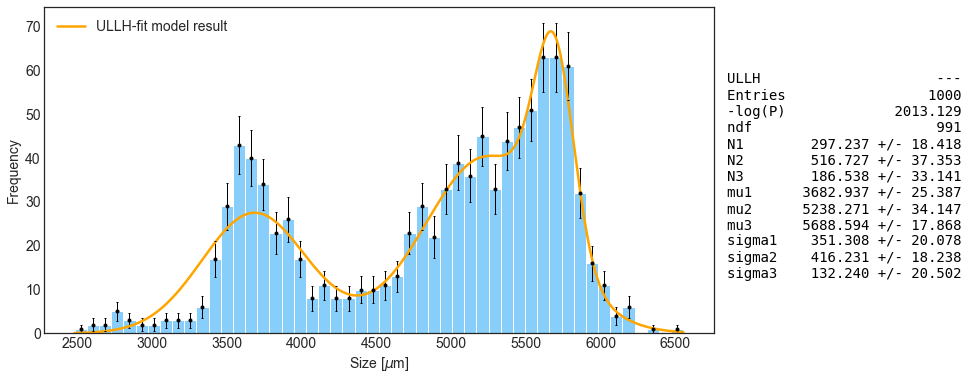

In [41]:
fig, ax = plt.subplots(figsize=(12, 6))
N_bins = 50

p0 = [300, 516, 186, 3682, 5238, 5688, 351, 416, 132]

negativlogp_value, Ndof_value, par, par_err = aas.ullhfit(data, threegauss, threegauss_plot, p0, xmin, xmax, N_bins, ax, plot=True, 
           funclabel='ULLH', d_xy=[1.02, 0.8]);

ax.set_xlabel('Size [$\mu$m]', fontsize=14)


#xaxis = np.linspace(10,70,10000)
#ax.plot(xaxis, doublegauss(xaxis, *p0))

if SaveFig:
        fig.savefig('fig423.pdf', dpi=600)



In [43]:
aas.chi2_hist(data, threegauss, par, N_bins)

The reduced Chi2 is: 25524.3518 with a p-value of: 0.0000


(25524.35175252378, 0.0, 81.46000000000004)